# <center>Welcome FSP solved with local search based metaheuristics</center>

This notebook presents a practical approach to solving the flowshop problem by implementing well-known local search based metaheuristics. These metaheuristics are effective in generating high-quality solutions for large instances of the problem, requiring only a reasonable amount of computational resources. Compared to heuristics, local search metaheuristics are more effective for solving the flowshop problem because they can escape from local optima and find better solutions

# Table of Contents

1. [Data utils](#Data-utils)
2. [Neighborhood generation](#Neighborhood-generation)
3. [Local Based Metaheuristics](#Local-Based-Metaheuristics)
4. [Tests](#Tests)
<!-- 2. 1. [SWAP](#SWAP)
4. [Random SWAP](#Random-SWAP)
5. [Best SWAP](#Best-SWAP)
6. [First Admissible SWAP](#First-Admissible-SWAP)
7. [First and Best Admissible SWAP](#First-and-Best-Admissible-SWAP) -->

## Data utils

In [150]:
import numpy as np
import random
import time
import math
import pandas as pd
import matplotlib.pyplot as plt
from utils.benchmarks import benchmarks, upper_bound
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from utils.utils import read_flow_shop_data

### Path Cost calculation function :
Used to calculate the cost of current node, which is the correct cost starting for the actual path of executed jobs

In [151]:
def calculate_makespan(processing_times, sequence):
    n_jobs = len(sequence)
    n_machines = len(processing_times[0])
    end_time = [[0] * (n_machines + 1) for _ in range(n_jobs + 1)]

    for j in range(1, n_jobs + 1):
        for m in range(1, n_machines + 1):
            end_time[j][m] = max(end_time[j][m - 1], end_time[j - 1]
                                 [m]) + processing_times[sequence[j - 1]][m - 1]

    return end_time[n_jobs][n_machines]

### Random data for tests

In [152]:
nb_jobs = 20
nb_machines = 5

In [189]:
rnd_data = np.random.randint(size=(nb_jobs,nb_machines), low=5, high=120)
permutation = np.random.permutation(nb_jobs).tolist()
print(rnd_data, "\n")
print('Initial solution:', permutation, "\n")

Cmax = calculate_makespan(rnd_data, permutation)
print(f'Makespan: {Cmax}')

[[ 53  63  12  65 119]
 [ 22  79  96  24  45]
 [ 38 117   6  46  10]
 [  7  83 106  21  28]
 [ 75 118  12  36  82]
 [106  99  75  36 103]
 [ 64  16  23  47  47]
 [ 27  28  67  72  61]
 [  8  41  12  31  34]
 [ 80  60  96  22  77]
 [ 84  53 103  21  29]
 [116  97  39  43   5]
 [ 95  75  92  66 109]
 [ 81  14  36  60  34]
 [ 13   9  29  56  19]
 [ 75  95  29  59 114]
 [ 64  88  11  59  54]
 [ 83 113  23  45 109]
 [ 40 113 110 116  94]
 [ 29  73  84  18  45]] 

Initial solution: [0, 7, 12, 2, 3, 6, 10, 9, 19, 1, 5, 15, 13, 16, 11, 14, 18, 8, 17, 4] 

Makespan: 1791


### Gantt graph generator

In [154]:
def generate_gantt_chart(processing_times, seq, interval=50, labeled=True):
    data = processing_times.T
    nb_jobs, nb_machines = processing_times.shape
    schedules = np.zeros((nb_machines, nb_jobs), dtype=dict)
    # schedule first job alone first
    task = {"name": "job_{}".format(
        seq[0]+1), "start_time": 0, "end_time": data[0][seq[0]]}

    schedules[0][0] = task
    for m_id in range(1, nb_machines):
        start_t = schedules[m_id-1][0]["end_time"]
        end_t = start_t + data[m_id][0]
        task = {"name": "job_{}".format(
            seq[0]+1), "start_time": start_t, "end_time": end_t}
        schedules[m_id][0] = task

    for index, job_id in enumerate(seq[1::]):
        start_t = schedules[0][index]["end_time"]
        end_t = start_t + data[0][job_id]
        task = {"name": "job_{}".format(
            job_id+1), "start_time": start_t, "end_time": end_t}
        schedules[0][index+1] = task
        for m_id in range(1, nb_machines):
            start_t = max(schedules[m_id][index]["end_time"],
                          schedules[m_id-1][index+1]["end_time"])
            end_t = start_t + data[m_id][job_id]
            task = {"name": "job_{}".format(
                job_id+1), "start_time": start_t, "end_time": end_t}
            schedules[m_id][index+1] = task

    # create a new figure
    fig, ax = plt.subplots(figsize=(18, 8))

    # set y-axis ticks and labels
    y_ticks = list(range(len(schedules)))
    y_labels = [f'Machine {i+1}' for i in y_ticks]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # calculate the total time
    total_time = max([job['end_time'] for proc in schedules for job in proc])

    # set x-axis limits and ticks
    ax.set_xlim(0, total_time)
    x_ticks = list(range(0, total_time+1, interval))
    ax.set_xticks(x_ticks)

    # set grid lines
    ax.grid(True, axis='x', linestyle='--')

    # create a color dictionary to map each job to a color
    color_dict = {}
    for proc in schedules:
        for job in proc:
            if job['name'] not in color_dict:
                color_dict[job['name']] = (np.random.uniform(
                    0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1))

    # plot the bars for each job on each processor
    for i, proc in enumerate(schedules):
        for job in proc:
            start = job['start_time']
            end = job['end_time']
            duration = end - start
            color = color_dict[job['name']]
            ax.barh(i, duration, left=start, height=0.5,
                    align='center', color=color, alpha=0.8)
            if labeled:
                # add job labels
                label_x = start + duration/2
                label_y = i
                ax.text(
                    label_x, label_y, job['name'][4:], ha='center', va='center', fontsize=10)

    plt.show()

### INITIAL SOLUTION METHODS

In [155]:
from utils.initial_sol_methods import neh_algorithm
from utils.initial_sol_methods import PRSKE
from utils.initial_sol_methods import ham_heuristic

## Neighborhood generation

### SWAP

In [156]:
def swap(solution, i, k):
    sol = solution.copy()
    sol[i], sol[k] = sol[k], sol[i]
    return sol

### Random SWAP

In [157]:
def random_swap(solution, processing_times):
    i = random.choice(list(solution))
    j = random.choice(list(solution))

    while i == j:
        j = random.choice(list(solution))

    new_solution = swap(solution, i, j)
    
    return new_solution, calculate_makespan(processing_times, new_solution)

In [158]:
neighbor_sol, neighbor_cmax = random_swap(permutation, rnd_data)

print("Original_solution: ", permutation)
print("Cmax = ", Cmax)

print("\nNeighbor_solution: ", neighbor_sol)
print("Neighor_cmax = ", neighbor_cmax)

Original_solution:  [17, 5, 3, 13, 11, 7, 4, 15, 18, 0, 16, 19, 8, 1, 9, 12, 6, 14, 10, 2]
Cmax =  1653

Neighbor_solution:  [17, 5, 3, 13, 11, 7, 4, 15, 18, 6, 16, 19, 8, 1, 9, 12, 0, 14, 10, 2]
Neighor_cmax =  1674


### Best SWAP

In [159]:
def best_swap(solution, processing_times):
    sequence = solution.copy()
    num_jobs = len(solution)
    Cmax = calculate_makespan(processing_times, solution)

    for i in range(num_jobs):
        for j in range(i+1, num_jobs):
            new_solution = swap(sequence, i, j)
            makespan = calculate_makespan(processing_times, new_solution)

            if makespan < Cmax:
                sequence = new_solution
                Cmax = makespan

    return sequence, Cmax

In [190]:
neighbor_sol, neighbor_cmax = best_swap(permutation, rnd_data)

print("Original_solution: ", permutation)
print("Cmax = ", Cmax)

print("\nNeighbor_solution: ", neighbor_sol)
print("Neighor_cmax = ", neighbor_cmax)

Original_solution:  [0, 7, 12, 2, 3, 6, 10, 9, 19, 1, 5, 15, 13, 16, 11, 14, 18, 8, 17, 4]
Cmax =  1791

Neighbor_solution:  [18, 7, 12, 0, 4, 6, 10, 9, 19, 1, 5, 15, 13, 16, 11, 14, 3, 8, 17, 2]
Neighor_cmax =  1597


### First Admissible SWAP

In [161]:
def first_admissible_swap(solution, processing_times):

    num_jobs = len(solution)
    Cmax = calculate_makespan(processing_times, solution)

    for i in range(num_jobs):
        for j in range(i+1, num_jobs):
            new_solution = swap(solution, i, j)
            makespan = calculate_makespan(processing_times, new_solution)

            if makespan < Cmax:
                return new_solution, makespan

    return solution, Cmax 

In [191]:
neighbor_sol, neighbor_cmax = first_admissible_swap(permutation, rnd_data)

print("Original_solution: ", permutation)
print("Cmax = ", Cmax)

print("\nNeighbor_solution: ", neighbor_sol)
print("Neighor_cmax = ", neighbor_cmax)

Original_solution:  [0, 7, 12, 2, 3, 6, 10, 9, 19, 1, 5, 15, 13, 16, 11, 14, 18, 8, 17, 4]
Cmax =  1791

Neighbor_solution:  [2, 7, 12, 0, 3, 6, 10, 9, 19, 1, 5, 15, 13, 16, 11, 14, 18, 8, 17, 4]
Neighor_cmax =  1745


### First and Best Admissible SWAP

In [163]:
def fba_swap(solution, processing_times, best_global_sol):
    sequence = solution.copy()
    num_jobs = len(sequence)
    Cmax = calculate_makespan(processing_times, sequence)
    Smax = calculate_makespan(processing_times, best_global_sol)
    for i in range(num_jobs):
        for j in range(i+1, num_jobs):
            new_solution = swap(solution, i, j)
            makespan = calculate_makespan(processing_times, new_solution)

            # First improving solution
            if makespan < Cmax:
                # Improves the global solution
                if makespan < Smax:
                    return new_solution, makespan, new_solution 
                Cmax = makespan
                sequence = new_solution                

    return sequence, Cmax, best_global_sol 

In [192]:
best_global = np.random.permutation(nb_jobs).tolist()

while calculate_makespan(rnd_data, best_global) > Cmax:
    best_global = np.random.permutation(nb_jobs).tolist()

neighbor_sol, neighbor_cmax, best_global_found = fba_swap(permutation, rnd_data, best_global)

print("Original_solution: ", permutation)
print("Cmax = ", Cmax)

print("\nBest_original_global_solution: ", best_global)
print("Best_global_initial_cmax = ", calculate_makespan(rnd_data, best_global))

print("\nNeighbor_solution: ", neighbor_sol)
print("Neighor_cmax = ", neighbor_cmax)

print("\nBest_global_solution: ", best_global_found)
print("Best_global_cmax = ", calculate_makespan(rnd_data, best_global_found))

Original_solution:  [0, 7, 12, 2, 3, 6, 10, 9, 19, 1, 5, 15, 13, 16, 11, 14, 18, 8, 17, 4]
Cmax =  1791

Best_original_global_solution:  [11, 9, 15, 18, 5, 0, 12, 8, 7, 2, 1, 10, 3, 4, 14, 19, 13, 6, 17, 16]
Best_global_initial_cmax =  1766

Neighbor_solution:  [2, 7, 12, 0, 3, 6, 10, 9, 19, 1, 5, 15, 13, 16, 11, 14, 18, 8, 17, 4]
Neighor_cmax =  1745

Best_global_solution:  [2, 7, 12, 0, 3, 6, 10, 9, 19, 1, 5, 15, 13, 16, 11, 14, 18, 8, 17, 4]
Best_global_cmax =  1745


## Local Based Metaheuristics

### Simulated annealing (RS) 

#### General method to get neighbors (except first and best admissible)

In [165]:
def get_neighbor(processing_times, solution, method='random_swap'):
    if method == 'random_swap':
        sol, val = random_swap(solution, processing_times)
    elif method == 'best_swap':
        sol, val = best_swap(solution, processing_times)
    elif method == 'first_admissible_swap':
        sol, val = first_admissible_swap(solution, processing_times)
    else:
        i = random.randint(0, 2)
        if i == 0:
            sol, val = random_swap(solution, processing_times)
        elif i == 1:
            sol, val = best_swap(solution, processing_times)
        elif i == 2:
            sol, val = first_admissible_swap(solution, processing_times)
    return sol, val

In [166]:
def RS(processing_times, initial_solution, temp, method='random_swap', alpha=0.6, nb_palier= 10, it_max=100):
    
    start_time = time.time()
    solution = initial_solution.copy()
    makespan = calculate_makespan(processing_times, solution)
    print('init_sol: ',solution, ' makespan = ', makespan, "\n")
    it = 0
    while it < it_max:
        for i in range(nb_palier):
            sol, value = get_neighbor(processing_times, solution, method)
            # print('Swap_sol: ',sol,' makespan = ', value)
            delta = makespan - value
            if delta > 0:
                solution = sol
                makespan = value
            else:
                if random.uniform(0, 1) < math.exp(delta / temp):
                    solution = sol
        temp = alpha * temp
        it += 1
    print("Elapsed time:", time.time()-start_time, "seconds")
    return solution

### RS with first and best admissible swap 

In [167]:
def RS_fba(processing_times, initial_solution, intitial_global, temp, alpha=0.6, nb_palier= 1, it_max=100):


    start_time = time.time()
    solution = initial_solution.copy()
    makespan = calculate_makespan(processing_times, solution)
    print('init_sol: ',solution, ' makespan = ', makespan)
    it = 0
    print('initial_global_solution: ',intitial_global, ' global_makespan = ', calculate_makespan(processing_times, intitial_global), "\n")
    best_global = intitial_global.copy()
    while it < it_max :
        for i in range(nb_palier):
            sol, value, best_global = fba_swap(solution, processing_times, best_global)
            # print('FBA_swap_sol: ',sol,' makespan = ', value)
            delta = makespan - value
            if delta > 0:
                solution = sol
                makespan = value
            else:
                if random.uniform(0, 1) < math.exp(delta / temp):
                    solution = sol
        temp = alpha * temp
        it += 1
    print("Elapsed time:", time.time()-start_time, "seconds")
    return solution, best_global

### Finding optimal params

In [168]:
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)
benchmark = benchmarks[0][2].T
benchmark

array([[54, 79, 16, 66, 58],
       [83,  3, 89, 58, 56],
       [15, 11, 49, 31, 20],
       [71, 99, 15, 68, 85],
       [77, 56, 89, 78, 53],
       [36, 70, 45, 91, 35],
       [53, 99, 60, 13, 53],
       [38, 60, 23, 59, 41],
       [27,  5, 57, 49, 69],
       [87, 56, 64, 85, 13],
       [76,  3,  7, 85, 86],
       [91, 61,  1,  9, 72],
       [14, 73, 63, 39,  8],
       [29, 75, 41, 41, 49],
       [12, 47, 63, 56, 47],
       [77, 14, 47, 40, 87],
       [32, 21, 26, 54, 58],
       [87, 86, 75, 77, 18],
       [68,  5, 77, 51, 68],
       [94, 77, 40, 31, 28]])

In [169]:
# Définir l'espace des paramètres
space = [
    Real(0.5, 0.9, name='alpha'),
    Integer(5, 20, name='nb_palier'),
    Integer(50, 200, name='it_max')
]

processing_times = benchmark
initial_solution = permutation
# Fonction objectif à minimiser
@use_named_args(space)
def objective(**params):
    alpha = params['alpha']
    nb_palier = params['nb_palier']
    it_max = params['it_max']
    # Vous devez définir `processing_times` et `initial_solution`
    result = RS(processing_times, initial_solution, temp=100, alpha=alpha, nb_palier=nb_palier, it_max=it_max)
    return calculate_makespan(processing_times, result)

# Lancer l'optimisation
result = gp_minimize(objective, space, n_calls=50, random_state=0)
# Affichage des meilleurs paramètres trouvés
print("Meilleurs paramètres: alpha={}, nb_palier={}, it_max={}".format(
    result.x[0], result.x[1], result.x[2]))

init_sol:  [17, 5, 3, 13, 11, 7, 4, 15, 18, 0, 16, 19, 8, 1, 9, 12, 6, 14, 10, 2]  makespan =  1549 

Elapsed time: 0.23533201217651367 seconds
init_sol:  [17, 5, 3, 13, 11, 7, 4, 15, 18, 0, 16, 19, 8, 1, 9, 12, 6, 14, 10, 2]  makespan =  1549 

Elapsed time: 0.11441516876220703 seconds
init_sol:  [17, 5, 3, 13, 11, 7, 4, 15, 18, 0, 16, 19, 8, 1, 9, 12, 6, 14, 10, 2]  makespan =  1549 

Elapsed time: 0.050687551498413086 seconds
init_sol:  [17, 5, 3, 13, 11, 7, 4, 15, 18, 0, 16, 19, 8, 1, 9, 12, 6, 14, 10, 2]  makespan =  1549 

Elapsed time: 0.1739978790283203 seconds
init_sol:  [17, 5, 3, 13, 11, 7, 4, 15, 18, 0, 16, 19, 8, 1, 9, 12, 6, 14, 10, 2]  makespan =  1549 

Elapsed time: 0.1511092185974121 seconds
init_sol:  [17, 5, 3, 13, 11, 7, 4, 15, 18, 0, 16, 19, 8, 1, 9, 12, 6, 14, 10, 2]  makespan =  1549 



Elapsed time: 0.17914509773254395 seconds
init_sol:  [17, 5, 3, 13, 11, 7, 4, 15, 18, 0, 16, 19, 8, 1, 9, 12, 6, 14, 10, 2]  makespan =  1549 

Elapsed time: 0.1850428581237793 seconds
init_sol:  [17, 5, 3, 13, 11, 7, 4, 15, 18, 0, 16, 19, 8, 1, 9, 12, 6, 14, 10, 2]  makespan =  1549 

Elapsed time: 0.1474146842956543 seconds
init_sol:  [17, 5, 3, 13, 11, 7, 4, 15, 18, 0, 16, 19, 8, 1, 9, 12, 6, 14, 10, 2]  makespan =  1549 

Elapsed time: 0.11933207511901855 seconds
init_sol:  [17, 5, 3, 13, 11, 7, 4, 15, 18, 0, 16, 19, 8, 1, 9, 12, 6, 14, 10, 2]  makespan =  1549 

Elapsed time: 0.0511474609375 seconds
init_sol:  [17, 5, 3, 13, 11, 7, 4, 15, 18, 0, 16, 19, 8, 1, 9, 12, 6, 14, 10, 2]  makespan =  1549 

Elapsed time: 0.23348045349121094 seconds
init_sol:  [17, 5, 3, 13, 11, 7, 4, 15, 18, 0, 16, 19, 8, 1, 9, 12, 6, 14, 10, 2]  makespan =  1549 

Elapsed time: 0.024276256561279297 seconds
init_sol:  [17, 5, 3, 13, 11, 7, 4, 15, 18, 0, 16, 19, 8, 1, 9, 12, 6, 14, 10, 2]  makespan =  1549

## Tests

We can adjust the swapping method to see the differences in tests

In [193]:
optimal_alpha = result.x[0]
optimal_Nb_palier = result.x[1]
optimal__it_max = result.x[2]
best_global = np.random.permutation(nb_jobs).tolist()
while calculate_makespan(rnd_data, best_global) > Cmax:
    best_global = np.random.permutation(nb_jobs).tolist()

benchmark

array([[54, 79, 16, 66, 58],
       [83,  3, 89, 58, 56],
       [15, 11, 49, 31, 20],
       [71, 99, 15, 68, 85],
       [77, 56, 89, 78, 53],
       [36, 70, 45, 91, 35],
       [53, 99, 60, 13, 53],
       [38, 60, 23, 59, 41],
       [27,  5, 57, 49, 69],
       [87, 56, 64, 85, 13],
       [76,  3,  7, 85, 86],
       [91, 61,  1,  9, 72],
       [14, 73, 63, 39,  8],
       [29, 75, 41, 41, 49],
       [12, 47, 63, 56, 47],
       [77, 14, 47, 40, 87],
       [32, 21, 26, 54, 58],
       [87, 86, 75, 77, 18],
       [68,  5, 77, 51, 68],
       [94, 77, 40, 31, 28]])

### Random initial solution

#### Without FBA swapping method

In [194]:
rs_solution = RS(benchmark, permutation, 5, method='random_swap',alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)

init_sol:  [0, 7, 12, 2, 3, 6, 10, 9, 19, 1, 5, 15, 13, 16, 11, 14, 18, 8, 17, 4]  makespan =  1459 

Elapsed time: 0.21894264221191406 seconds


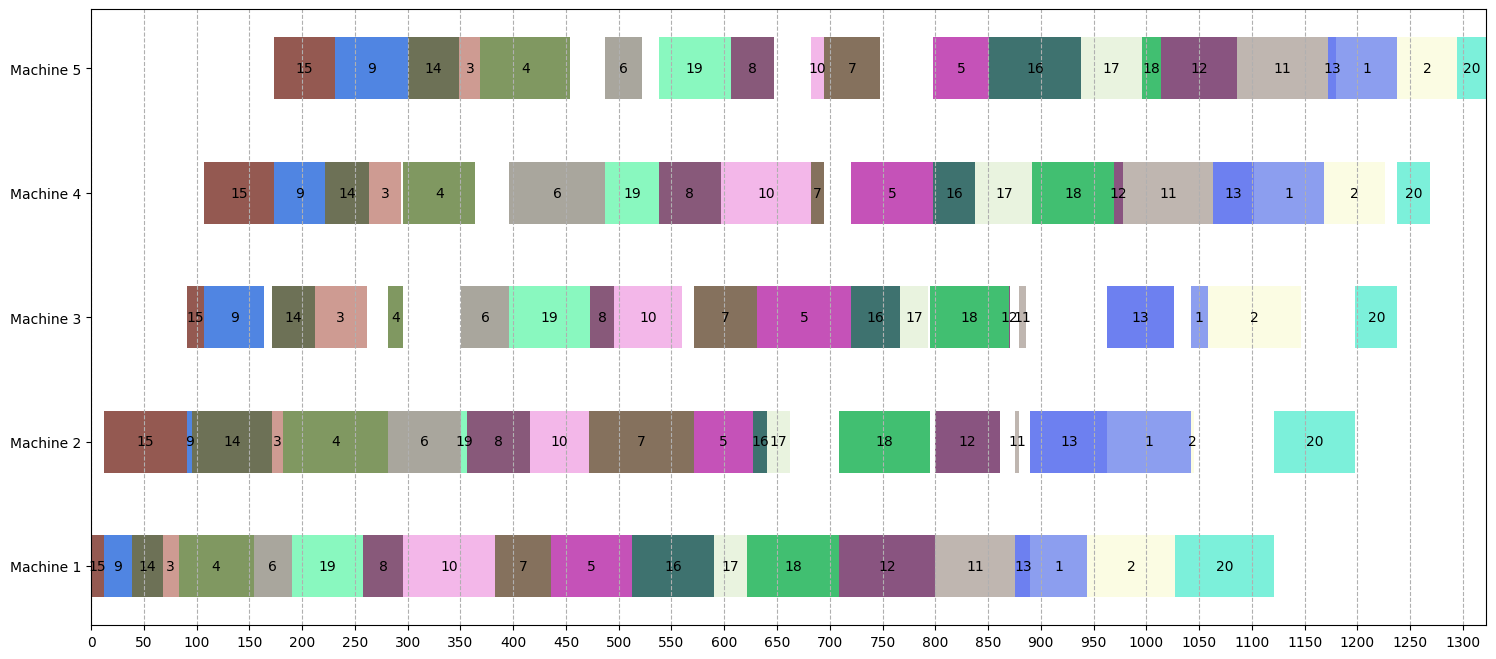

In [195]:
generate_gantt_chart(benchmark, rs_solution)

#### With FBA swapping method

In [196]:
rs_fba_solution, best_global_found = RS_fba(benchmark, permutation, best_global, 5,alpha=optimal_alpha, nb_palier=optimal_Nb_palier, it_max=optimal__it_max)

init_sol:  [0, 7, 12, 2, 3, 6, 10, 9, 19, 1, 5, 15, 13, 16, 11, 14, 18, 8, 17, 4]  makespan =  1459
initial_global_solution:  [16, 0, 19, 8, 12, 3, 14, 9, 13, 6, 4, 17, 5, 15, 18, 1, 7, 10, 11, 2]  global_makespan =  1577 

Elapsed time: 33.17660713195801 seconds


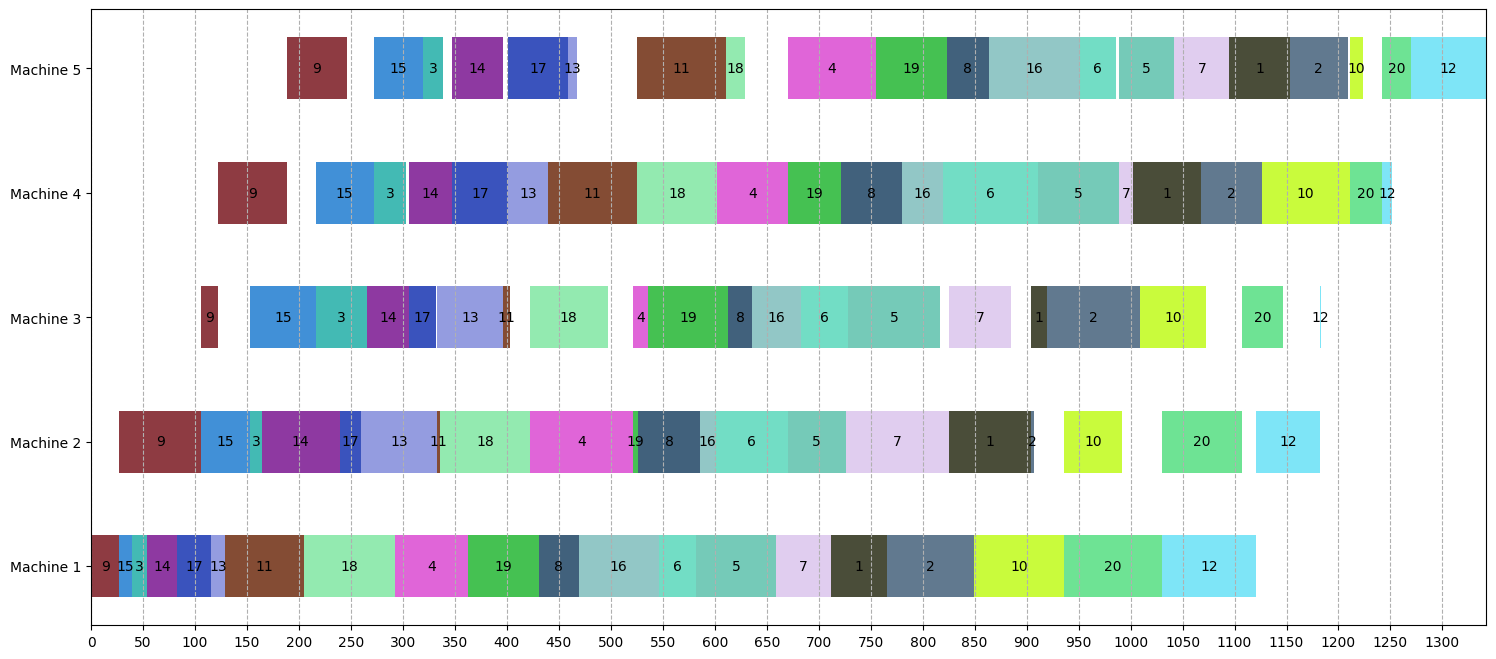

In [197]:
generate_gantt_chart(benchmark, rs_fba_solution)

In [198]:
print('Results of random:')
print(f'First sequence: {permutation} with a makespan of {calculate_makespan(benchmark, permutation)}.')
print('\nResults of RS:')
print(f'Best solution: {rs_solution} with a makespan of {calculate_makespan(benchmark, rs_solution)}.')
print('\nResults of RS_FBA:')
print(f'Best solution: {rs_fba_solution} with a makespan of {calculate_makespan(benchmark, rs_fba_solution)}.')
print(f'Best global solution: {best_global_found} with a makespan of {calculate_makespan(benchmark, best_global_found)}.')

Results of random:
First sequence: [0, 7, 12, 2, 3, 6, 10, 9, 19, 1, 5, 15, 13, 16, 11, 14, 18, 8, 17, 4] with a makespan of 1459.

Results of RS:
Best solution: [14, 8, 13, 2, 3, 5, 18, 7, 9, 6, 4, 15, 16, 17, 11, 10, 12, 0, 1, 19] with a makespan of 1297.

Results of RS_FBA:
Best solution: [8, 14, 2, 13, 16, 12, 10, 17, 3, 18, 7, 15, 5, 4, 6, 0, 1, 9, 19, 11] with a makespan of 1278.
Best global solution: [8, 14, 2, 13, 16, 12, 10, 17, 3, 18, 7, 15, 5, 4, 6, 0, 1, 9, 19, 11] with a makespan of 1278.


### NEH initial solution

#### Without FBA swapping method

In [199]:
initialSolution, makespan = neh_algorithm(benchmark)
rs_solution = RS(benchmark, initialSolution, 5)

init_sol:  [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19]  makespan =  1334 

Elapsed time: 0.13850808143615723 seconds


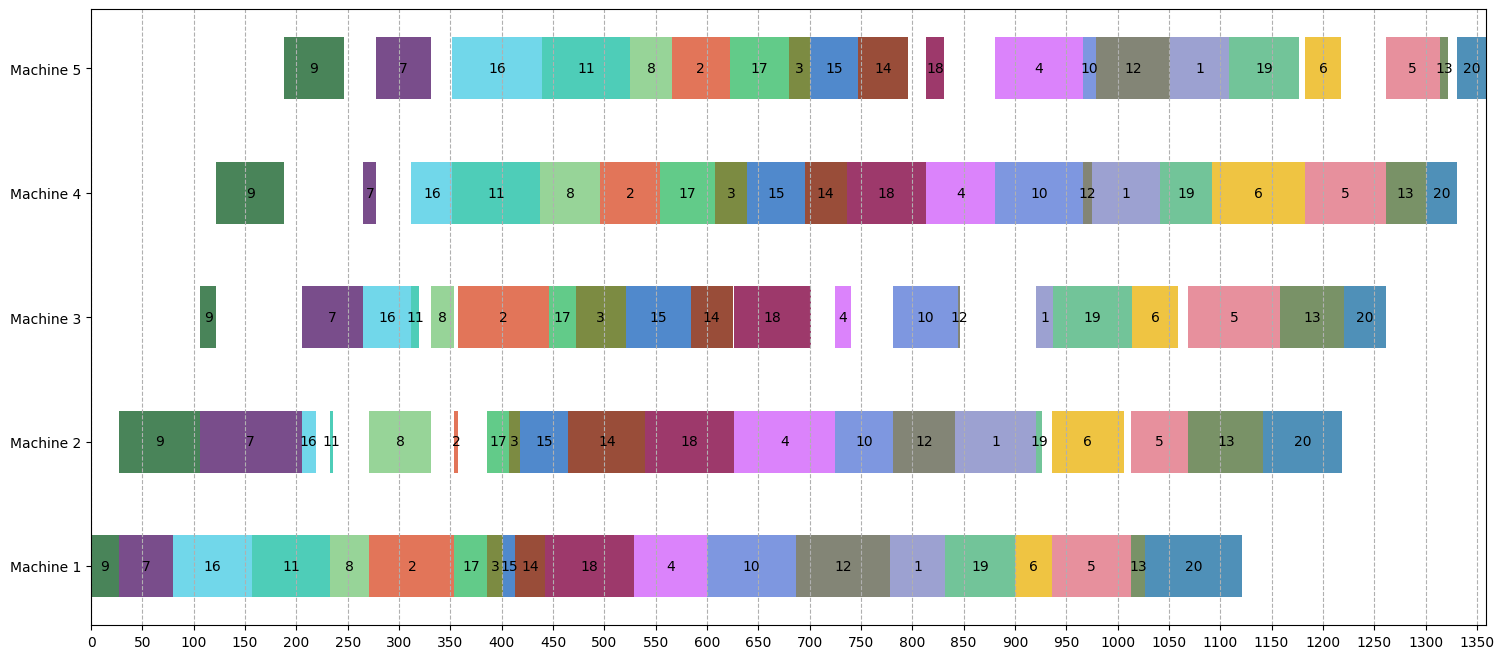

In [200]:
generate_gantt_chart(benchmark, initialSolution)    

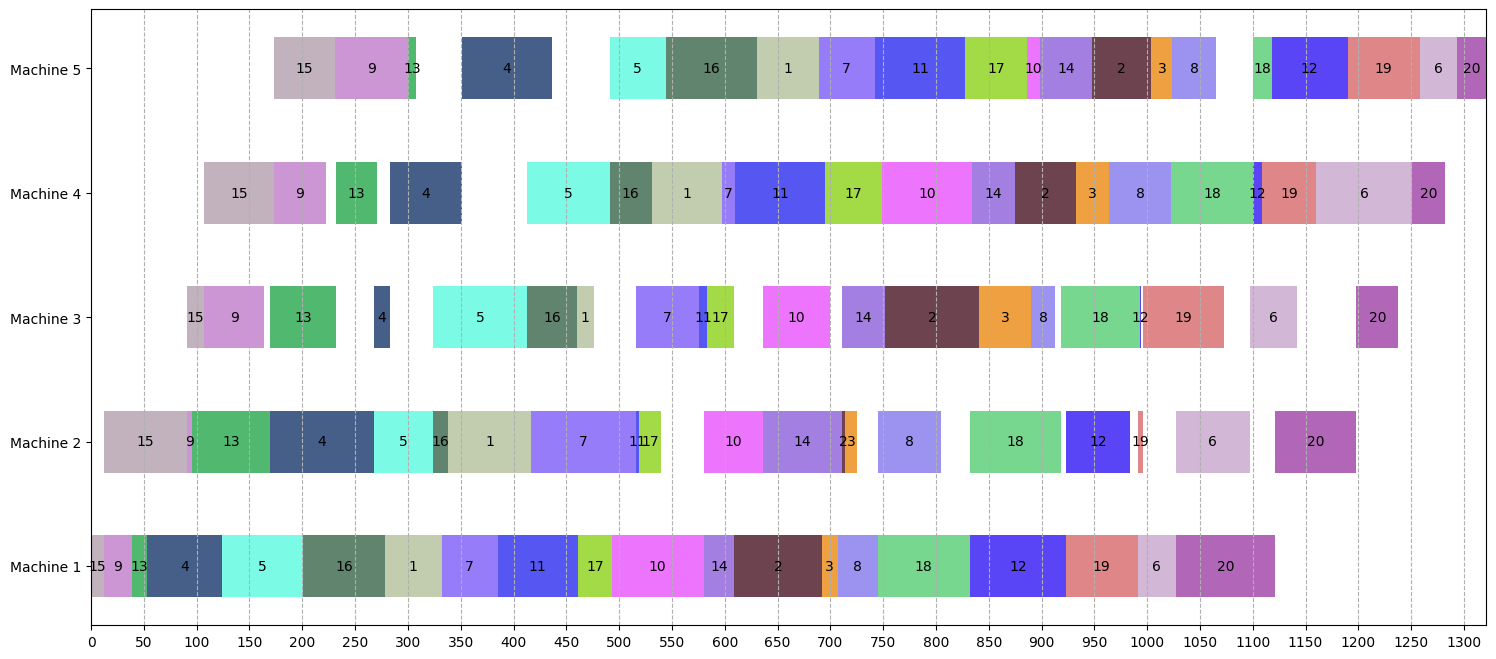

In [201]:
generate_gantt_chart(benchmark, rs_solution)    

#### With FBA swapping method

In [202]:
rs_fba_solution, best_global_found = RS_fba(benchmark, initialSolution, best_global, 5)

init_sol:  [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19]  makespan =  1334
initial_global_solution:  [16, 0, 19, 8, 12, 3, 14, 9, 13, 6, 4, 17, 5, 15, 18, 1, 7, 10, 11, 2]  global_makespan =  1577 

Elapsed time: 2.257904529571533 seconds


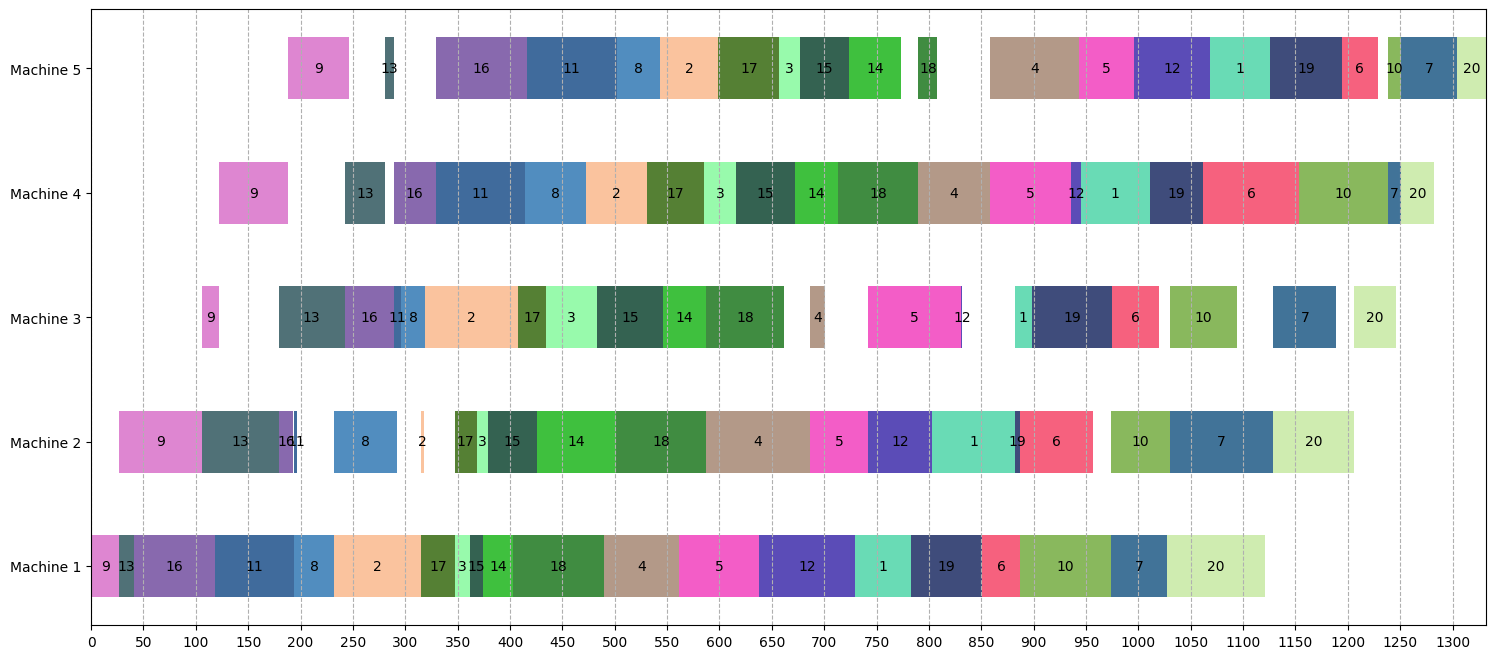

In [203]:
generate_gantt_chart(benchmark, rs_fba_solution)

In [204]:
print('Results of NEH:')
print(f'First sequence: {initialSolution} with a makespan of {makespan}.')
print('\nResults of RS:')
print(f'Best solution: {rs_solution} with a makespan of {calculate_makespan(benchmark, rs_solution)}.')
print('\nResults of RS_FBA:')
print(f'Best solution: {rs_fba_solution} with a makespan of {calculate_makespan(benchmark, rs_fba_solution)}.')
print(f'Best global solution: {best_global_found} with a makespan of {calculate_makespan(benchmark, best_global_found)}.')

Results of NEH:
First sequence: [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19] with a makespan of 1334.

Results of RS:
Best solution: [14, 8, 12, 3, 4, 15, 0, 6, 10, 16, 9, 13, 1, 2, 7, 17, 11, 18, 5, 19] with a makespan of 1297.

Results of RS_FBA:
Best solution: [8, 12, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 4, 11, 0, 18, 5, 9, 6, 19] with a makespan of 1305.
Best global solution: [8, 12, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 4, 11, 0, 18, 5, 9, 6, 19] with a makespan of 1305.


### PRSKE initial solution

#### Without FBA swapping method

In [205]:
initialSolution, makespan  = PRSKE(benchmark)
rs_solution = RS(benchmark, initialSolution, 5)

init_sol:  [3, 17, 10, 1, 9, 11, 6, 4, 19, 15, 18, 5, 0, 12, 8, 13, 14, 7, 16, 2]  makespan =  1593 

Elapsed time: 0.1487257480621338 seconds


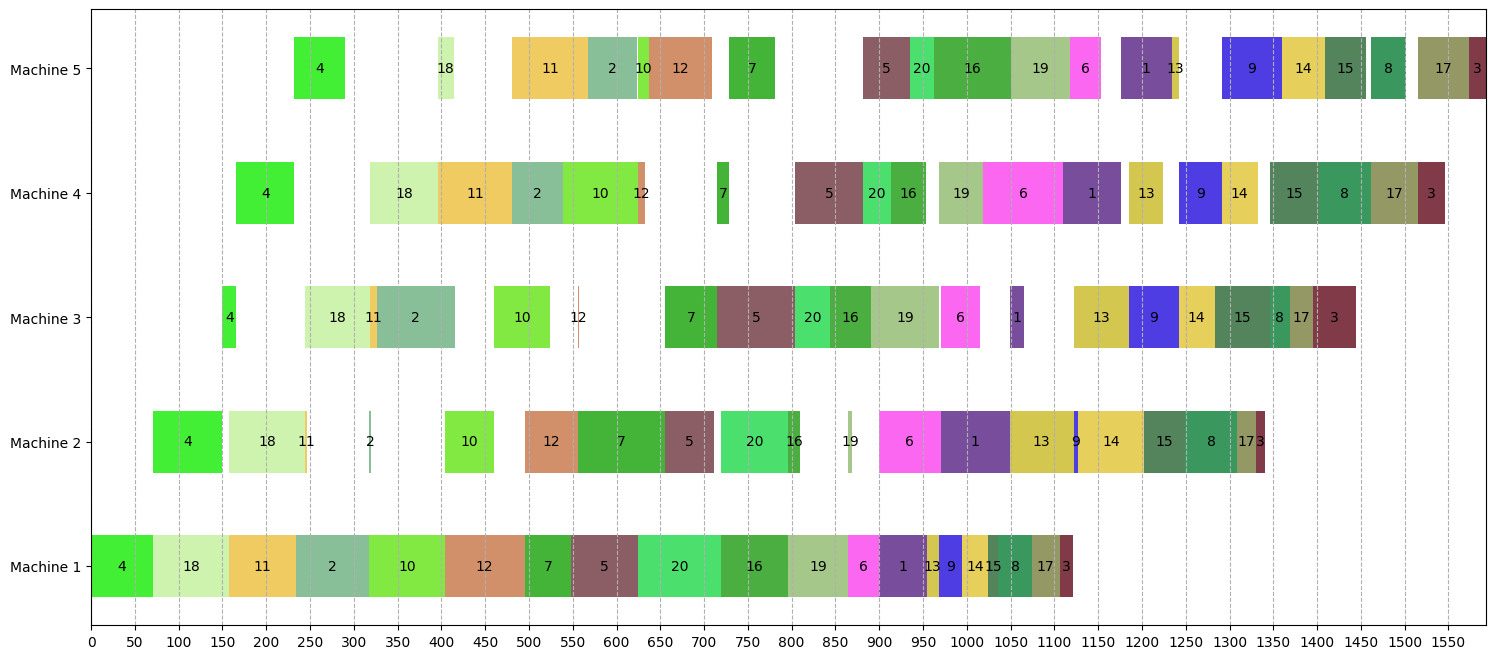

In [206]:
generate_gantt_chart(benchmark, initialSolution)

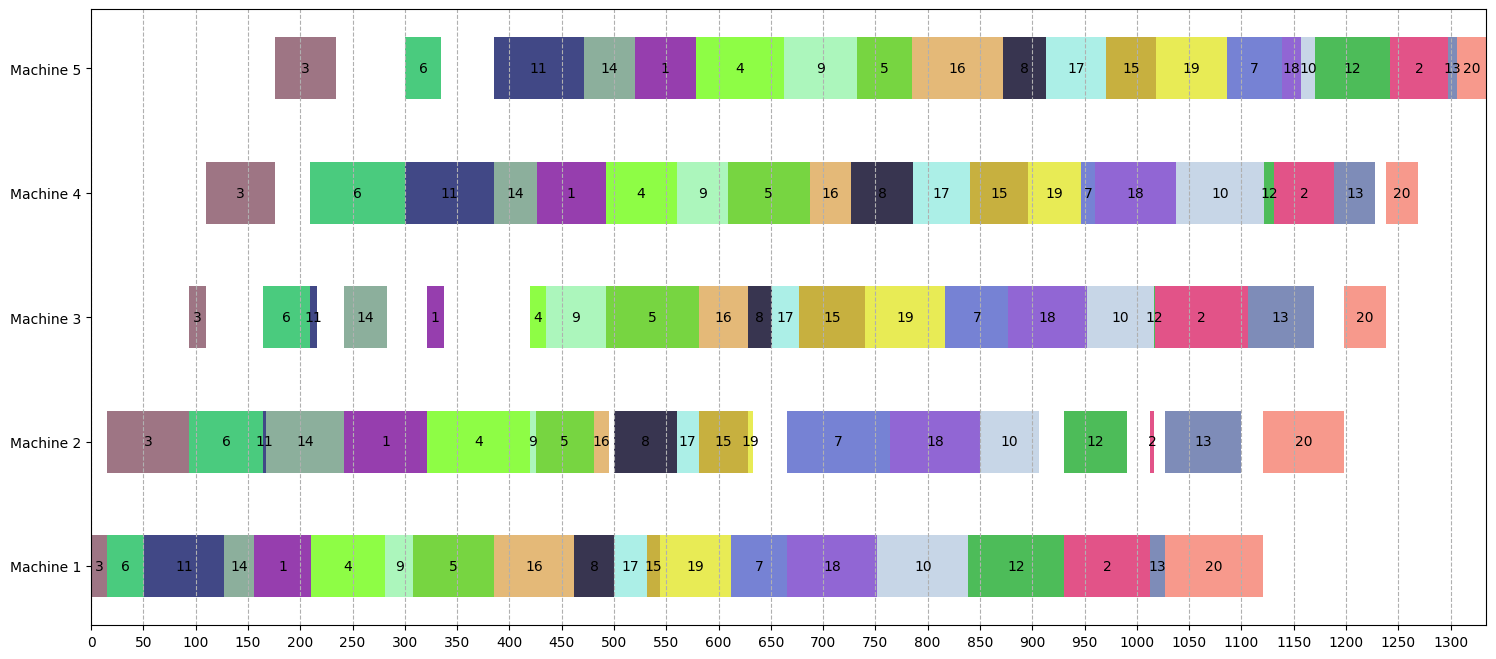

In [207]:
generate_gantt_chart(benchmark, rs_solution)

#### With FBA swapping method

In [208]:
rs_fba_solution, best_global_found = RS_fba(benchmark, initialSolution, best_global, 5)

init_sol:  [3, 17, 10, 1, 9, 11, 6, 4, 19, 15, 18, 5, 0, 12, 8, 13, 14, 7, 16, 2]  makespan =  1593
initial_global_solution:  [16, 0, 19, 8, 12, 3, 14, 9, 13, 6, 4, 17, 5, 15, 18, 1, 7, 10, 11, 2]  global_makespan =  1577 

Elapsed time: 1.8218789100646973 seconds


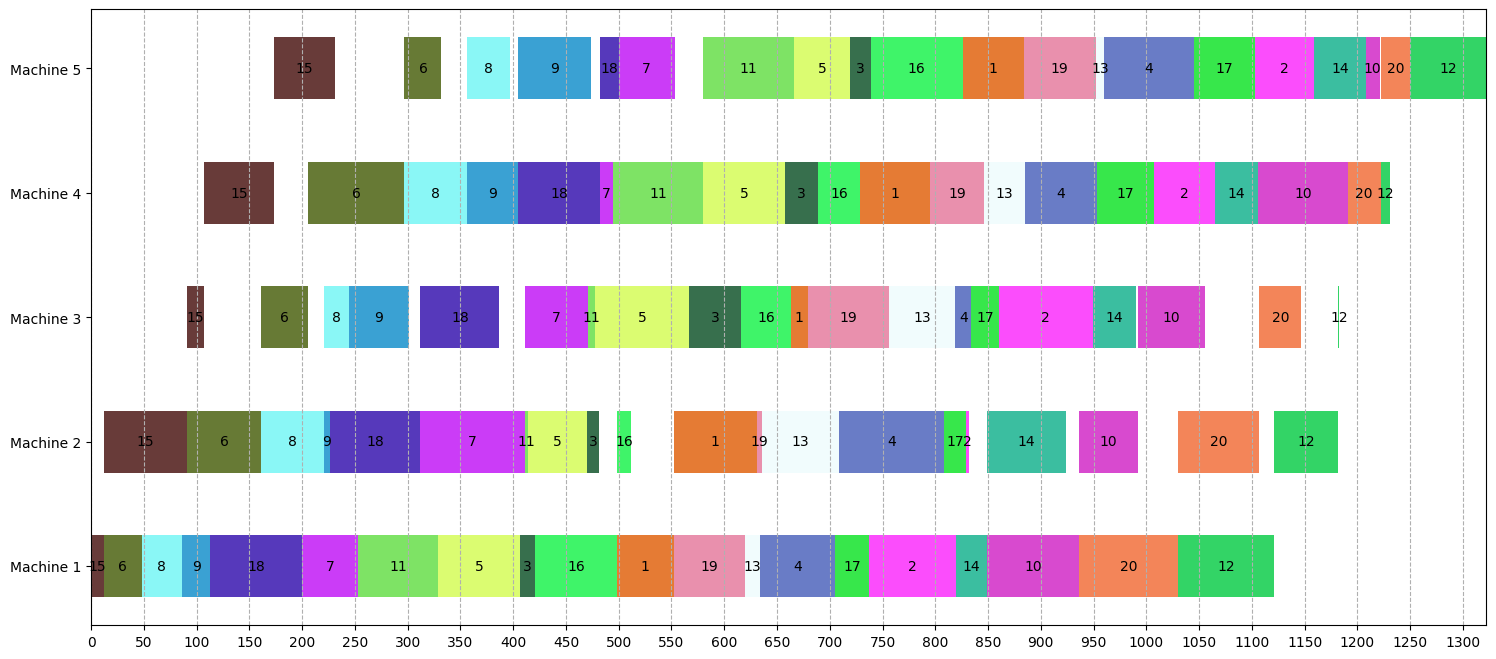

In [209]:
generate_gantt_chart(benchmark, rs_fba_solution)

In [210]:
print('Results of PRSKE:')
print(f'First sequence: {initialSolution} with a makespan of {makespan}.')
print('\nResults of RS:')
print(f'Best solution: {rs_solution} with a makespan of {calculate_makespan(benchmark, rs_solution)}')
print('\nResults of RS_FBA:')
print(f'Best solution: {rs_fba_solution} with a makespan of {calculate_makespan(benchmark, rs_fba_solution)}.')
print(f'Best global solution: {best_global_found} with a makespan of {calculate_makespan(benchmark, best_global_found)}.')

Results of PRSKE:
First sequence: [3, 17, 10, 1, 9, 11, 6, 4, 19, 15, 18, 5, 0, 12, 8, 13, 14, 7, 16, 2] with a makespan of 1593.

Results of RS:
Best solution: [2, 5, 10, 13, 0, 3, 8, 4, 15, 7, 16, 14, 18, 6, 17, 9, 11, 1, 12, 19] with a makespan of 1297

Results of RS_FBA:
Best solution: [14, 5, 7, 8, 17, 6, 10, 4, 2, 15, 0, 18, 12, 3, 16, 1, 13, 9, 19, 11] with a makespan of 1294.
Best global solution: [14, 5, 7, 8, 17, 6, 10, 4, 2, 15, 0, 18, 12, 3, 16, 1, 13, 9, 19, 11] with a makespan of 1294.
